In [85]:
import numpy as np
import sys
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mne
from brainda.algorithms.decomposition import (
    FBTRCA, FBTDCA, FBSCCA, FBECCA, FBDSP,
    generate_filterbank, generate_cca_references)
from numpy import ndarray
from brainda.algorithms.decomposition import *
from brainda.algorithms.decomposition.tdca import *
from brainda.algorithms.decomposition.cca import _trca_kernel, _trca_feature
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm

from collections import OrderedDict
from sklearn.pipeline import clone
from brainda.algorithms.utils.model_selection import (
    set_random_seeds, 
    generate_loo_indices, match_loo_indices)
from sklearn.metrics import balanced_accuracy_score
from pyinform.activeinfo import active_info
from pyinform.blockentropy import block_entropy

In [333]:
def load_egg(eeg, meta, classes, stim_duration=5, sfreq=300, filter=True, drop_chan=['time',' TRG',' X1',' X2',' X3',' A2']):
    trials = meta[1:,:2]
    times = []
    duration_samples = int(stim_duration*sfreq)
    for index, row in eeg.loc[eeg[' TRG']==16.0].iterrows():
        if index > 0 and eeg.iloc[index-1][' TRG'] == 0 and (not eeg.iloc[index:index+duration_samples][' TRG'].isin([18.0]).any()):
            times.append(row['time'])
    times = np.array(times)
    
    eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=drop_chan).to_numpy()[:duration_samples].T for t in times])
    if filter:
        eeg = mne.filter.filter_data(eeg, sfreq=sfreq, l_freq=5, h_freq=49, verbose=0, method='fir')
    eeg_temp = []
    for i in range(len(classes)):
        eeg_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                eeg_temp[j].append(eeg[i])
    eeg = np.array(eeg_temp).transpose(1,0,2,3)
    return eeg

def load_dataset(path="../data/eeg_recordings/32-class_speller/DSI-24/Simon/",
                sub_dirs=['run1/','run2/','run3/','run4/','run5/','run6/','run7/','run8/','run9/','run10/'],
                drop_chan=['time',' TRG',' X1',' X2',' X3',' A2'],
                duration=1.5,
                n_trials=2,
                n_classes=32,
                sfreq=300):
    n_channels = 25 - len(drop_chan)
    # load experimental dataset
    eeg_whole = np.zeros((n_trials*len(sub_dirs),n_classes,n_channels,int(duration*sfreq)))
    target_tab = {}
    for i_dir,sub_dir in enumerate(tqdm(sub_dirs, desc='Loading Data...', leave=False, file=sys.stdout)):
        data_path = path + sub_dir
        eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
        meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
        trials = meta[1:,:2]
        classes = np.unique(trials, axis=0)
        more_targets = {tuple(target):index for index,target in enumerate(classes)}
        target_tab.update(more_targets)
        eeg = load_egg(eeg, meta, classes, stim_duration=duration,filter=False,drop_chan=drop_chan)
        eeg_whole[i_dir*n_trials:(i_dir+1)*n_trials,:,:,:] = eeg
    eeg = eeg_whole
    target_by_trial = [list(target_tab.keys())] * n_trials*len(sub_dirs)
    print('\r', end='')
    print(eeg.shape, np.array(target_by_trial).shape)
    return eeg, target_by_trial, target_tab

def run_fbtrca(eeg, target_by_trial, target_tab, duration=1.0, onset_delay=42,srate=300, ensamble=True, return_prob=False,return_template_xcorr=False, return_matching_xcorr=False):
    eeg = np.copy(eeg)
    np.random.seed(64)
    np.random.shuffle(eeg)
    n_trials = eeg.shape[0]
    classes = range(32)
    n_classes = len(classes)
    # prob_matrix=np.zeros((n_classes,n_classes))
    y = np.array([list(target_tab.values())] * n_trials).T.reshape(-1)
    eeg_temp = eeg[:n_trials,classes,:,onset_delay:]
    X = eeg_temp.swapaxes(0,1).reshape(-1,*eeg_temp.shape[2:])


    freq_targets = np.array(target_by_trial)[0,:,0]
    phase_targets = np.array(target_by_trial)[0,:,1]
    n_harmonics = 5
    n_bands = 3
    Yf = generate_cca_references(
        freq_targets, srate, duration, 
        phases=phase_targets, 
        n_harmonics=n_harmonics)
    wp = [[8*i, 90] for i in range(1, n_bands+1)]
    ws = [[8*i-2, 95] for i in range(1, n_bands+1)]
    filterbank = generate_filterbank(
        wp, ws, srate, order=4, rp=1)
    filterweights = np.arange(1, len(filterbank)+1)**(-1.25) + 0.25
    set_random_seeds(64)
    l = 5
    models = OrderedDict([
        ('fbtrca', FBTRCA(
            filterbank, filterweights=filterweights,ensemble=ensamble)),
    ])
    events = []
    for j_class in classes:
        events.extend([str(target_by_trial[i_trial][j_class]) for i_trial in range(n_trials)])
    events = np.array(events)
    subjects = ['1'] * (n_classes*n_trials)
    meta = pd.DataFrame(data=np.array([subjects,events]).T, columns=["subject", "event"])
    set_random_seeds(42)
    loo_indices = generate_loo_indices(meta)

    for model_name in models:
        if model_name == 'fbtdca':
            filterX, filterY = np.copy(X[..., :int(srate*duration)+l]), np.copy(y)
        else:
            filterX, filterY = np.copy(X[..., :int(srate*duration)]), np.copy(y)
        
        filterX = filterX - np.mean(filterX, axis=-1, keepdims=True)

        n_loo = len(loo_indices['1'][events[0]])
        prob_matrices=np.zeros((n_loo,n_classes,n_classes))
        txcorr_matrices=np.zeros((n_loo,n_classes,n_classes))
        mxcorr_matrices=np.zeros((n_loo,n_classes,n_classes))
        loo_accs = []
        testYs = []
        pred_labelss = []
        for k in range(n_loo):
            train_ind, validate_ind, test_ind = match_loo_indices(
                k, meta, loo_indices)
            train_ind = np.concatenate([train_ind, validate_ind])

            trainX, trainY = filterX[train_ind], filterY[train_ind]
            testX, testY = filterX[test_ind], filterY[test_ind]

            model = clone(models[model_name]).fit(
                trainX, trainY,
                Yf=Yf
            )
            if return_template_xcorr:
                templates = np.copy(model.estimators_[0].templates_)
                # chan_n = 13
                U = np.copy(model.estimators_[0].Us_)[:, :, :model.n_components]
                U = np.concatenate(U, axis=-1)
                # Us = np.copy(model.estimators_[1].Us_)
                # for i_template, template in enumerate(templates):
                #     templates[i_template] = np.reshape((Us[i_template,:,:n_comp].T@template),(-1))
                new_templates=np.zeros((templates.shape[0],templates.shape[0]*templates.shape[2]))
                for i_template, template in enumerate(templates):
                    new_templates[i_template] = np.reshape((U.T@template),(-1))
                templates = np.copy(new_templates)
                for i in range(n_classes):
                    for j in range(n_classes):
                        # a1 = templates[i,chan_n]
                        # a2 = templates[j,chan_n]
                        a1 = templates[i]
                        a2 = templates[j]
                        txcorr_matrices[k,i,j] = pearsonr(a1,a2)[0]
            if return_matching_xcorr:
                templates = np.copy(model.estimators_[0].templates_)
                # Us = np.copy(model.estimators_[0].Us_)
                U = np.copy(model.estimators_[0].Us_)[:, :, :model.n_components]
                U = np.concatenate(U, axis=-1)
                eegX = model.transform_filterbank(np.copy(testX))[0]
                # new_templates=np.zeros((templates.shape[0],templates.shape[2]))
                # new_eegX = np.zeros((eegX.shape[0],eegX.shape[2]))
                new_templates=np.zeros((templates.shape[0],templates.shape[0]*templates.shape[2]))
                new_eegX = np.zeros((eegX.shape[0],eegX.shape[0]*eegX.shape[2]))
                for i_template, template in enumerate(templates):
                    # templates[i_template] = np.reshape((Us[i_template,:,:n_comp].T@template),(-1))
                    # print(np.reshape((Us[i_template,:,:n_comp].T@template),(-1)).shape)
                    # new_templates[i_template] = np.reshape((Us[i_template,:,:n_comp].T@template),(-1))
                    # templates[i_template] = np.reshape((U.T@template),(-1))
                    new_templates[i_template] = np.reshape((U.T@template),(-1))
                templates = np.copy(new_templates)
                for i_x, x in enumerate(eegX):
                    # eegX[i_x] = np.reshape((Us[i_x,:,:n_comp].T@x),(-1))
                    # new_eegX[i_x] = np.reshape((Us[i_x,:,:n_comp].T@x),(-1))
                    # eegX[i_x] = np.reshape((U.T@x),(-1))
                    new_eegX[i_x] = np.reshape((U.T@x),(-1))
                eegX = np.copy(new_eegX)
                for i in range(n_classes):
                    for j in range(n_classes):
                        # a1 = templates[i,chan_n]
                        # a2 = eegX[j,chan_n]
                        a1 = templates[i]
                        a2 = eegX[j]
                        mxcorr_matrices[k,i,j] = pearsonr(a1,a2)[0]
            if return_prob:
                # prob_matrix+=model.transform(testX)
                prob_matrices[k] = model.transform(testX)
            pred_labels = model.predict(testX)
            loo_accs.append(
                balanced_accuracy_score(testY, pred_labels))
            pred_labelss.extend(pred_labels)
            testYs.extend(testY)
    print("Model:{} LOO Acc:{:.2f}".format(model_name, np.mean(loo_accs)))
    if return_template_xcorr:
        return txcorr_matrices, accuracy_score(testYs, pred_labelss), model
    if return_matching_xcorr:
        return mxcorr_matrices, accuracy_score(testYs, pred_labelss), model
    if return_prob:
        return prob_matrices, accuracy_score(testYs, pred_labelss)
    return confusion_matrix(testYs, pred_labelss, normalize='true'), accuracy_score(testYs, pred_labelss), model

In [182]:
def load_egg(eeg, meta, classes, stim_duration=5, sfreq=300, filter=True, drop_chan=['time',' TRG',' X1',' X2',' X3',' A2']):
    trials = meta[1:,:2]
    times = []
    duration_samples = int(stim_duration*sfreq)
    for index, row in eeg.loc[eeg[' TRG']==16.0].iterrows():
        if index > 0 and eeg.iloc[index-1][' TRG'] == 0 and (not eeg.iloc[index:index+duration_samples][' TRG'].isin([18.0]).any()):
            times.append(row['time'])
    times = np.array(times)
    
    eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=drop_chan).to_numpy()[:duration_samples].T for t in times])
    if filter:
        eeg = mne.filter.filter_data(eeg, sfreq=sfreq, l_freq=5, h_freq=49, verbose=0, method='fir')
    eeg_temp = []
    for i in range(len(classes)):
        eeg_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                eeg_temp[j].append(eeg[i])
    eeg = np.array(eeg_temp).transpose(1,0,2,3)
    return eeg

def load_dataset(path="../data/eeg_recordings/32-class_speller/DSI-24/Simon/",
                sub_dirs=['run1/','run2/','run3/','run4/','run5/','run6/','run7/','run8/','run9/','run10/'],
                drop_chan=['time',' TRG',' X1',' X2',' X3',' A2'],
                duration=1.5,
                n_trials=2,
                n_classes=32,
                sfreq=300):
    n_channels = 25 - len(drop_chan)
    # load experimental dataset
    eeg_whole = np.zeros((n_trials*len(sub_dirs),n_classes,n_channels,int(duration*sfreq)))
    target_tab = {}
    for i_dir,sub_dir in enumerate(tqdm(sub_dirs, desc='Loading Data...', leave=False, file=sys.stdout)):
        data_path = path + sub_dir
        eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
        meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
        trials = meta[1:,:2]
        classes = np.unique(trials, axis=0)
        more_targets = {tuple(target):index for index,target in enumerate(classes)}
        target_tab.update(more_targets)
        eeg = load_egg(eeg, meta, classes, stim_duration=duration,filter=False,drop_chan=drop_chan)
        eeg_whole[i_dir*n_trials:(i_dir+1)*n_trials,:,:,:] = eeg
    eeg = eeg_whole
    target_by_trial = [list(target_tab.keys())] * n_trials*len(sub_dirs)
    print('\r', end='')
    print(eeg.shape, np.array(target_by_trial).shape)
    return eeg, target_by_trial, target_tab

def _trca_feature(
        X: ndarray, templates: ndarray, 
        Us: Optional[ndarray] = None,
        n_components: int = 1,
        ensemble: bool = True):
    rhos = []
    if not ensemble:
        for Xk, U in zip(templates, Us):
            a = U[:, :n_components].T@X
            b = U[:, :n_components].T@Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    else:
        U = Us[:, :, :n_components]
        U = np.concatenate(U, axis=-1)
        # print(U.shape)
        for Xk in templates:
            a = U.T@X
            b = U.T@Xk
            # print(b.shape)
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            # print(a.shape)
            rhos.append(pearsonr(a, b)[0])
    return rhos

class FilterBank(BaseEstimator, TransformerMixin):
    def __init__(self, 
            base_estimator: BaseEstimator, filterbank: Optional[List[ndarray]],
            n_jobs: Optional[int] = None):
        self.base_estimator = base_estimator
        self.filterbank = filterbank
        self.n_jobs = n_jobs

    def fit(self, X: ndarray, y: Optional[ndarray] = None, **kwargs):
        self.estimators_ = [
            clone(self.base_estimator) for _ in range(len(self.filterbank))]
        X = self.transform_filterbank(X)
        for i, est in enumerate(self.estimators_):
            est.fit(X[i], y, **kwargs)
        # def wrapper(est, X, y, kwargs):
        #     est.fit(X, y, **kwargs)
        #     return est
        # self.estimators_ = Parallel(n_jobs=self.n_jobs)(
        #     delayed(wrapper)(est, X[i], y, kwargs) for i, est in enumerate(self.estimators_))
        return self

    def transform(self, X: ndarray, **kwargs):
        X = self.transform_filterbank(X)
        feat = [est.transform(X[i], **kwargs) for i, est in enumerate(self.estimators_)]
        # def wrapper(est, X, kwargs):
        #     retval = est.transform(X, **kwargs)
        #     return retval
        # feat = Parallel(n_jobs=self.n_jobs)(
        #     delayed(wrapper)(est, X[i], kwargs) for i, est in enumerate(self.estimators_))
        feat = np.concatenate(feat, axis=-1)
        # print(feat.shape)
        return feat

    def transform_filterbank(self, X: ndarray):
        Xs = np.stack([sosfiltfilt(sos, X, axis=-1) for sos in self.filterbank])
        return Xs

class FilterBankSSVEP(FilterBank):
    """Filter bank analysis for SSVEP.
    
    """
    def __init__(self, 
        filterbank: List[ndarray],
        base_estimator: BaseEstimator,
        filterweights: Optional[ndarray] = None,
        n_jobs: Optional[int] = None):
        self.filterweights = filterweights
        super().__init__(
            base_estimator,
            filterbank,
            n_jobs=n_jobs
        )
    
    def transform(self, X: ndarray):
        features = super().transform(X)
        if self.filterweights is None:
            return features
        else:
            features = np.reshape(features, (features.shape[0], len(self.filterbank), -1))
            # print(features.shape)
            return np.sum(features*self.filterweights[np.newaxis, :, np.newaxis], axis=1)

class TRCA(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(self, 
            n_components: int = 1, 
            ensemble: bool = True,
            n_jobs: Optional[int] = None):
        self.n_components = n_components
        self.ensemble = ensemble
        self.n_jobs = n_jobs
    
    def fit(self, 
            X: ndarray, 
            y: ndarray,
            Yf: Optional[ndarray] = None):
        self.classes_ = np.unique(y)
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        self.templates_ = np.stack([np.mean(X[y==label], axis=0) for label in self.classes_])

        self.Us_ = np.stack([_trca_kernel(X[y==label]) for label in self.classes_])
        return self

    def transform(self, X: ndarray):
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        n_components = self.n_components
        templates = self.templates_
        Us = self.Us_
        ensemble = self.ensemble
        rhos = Parallel(n_jobs=self.n_jobs)(
            delayed(partial(_trca_feature, Us=Us, n_components=n_components, ensemble=ensemble))(a, templates) for a in X)
        rhos = np.stack(rhos)
        return rhos
    
    def predict(self, X: ndarray):
        feat = self.transform(X)
        labels = self.classes_[np.argmax(feat, axis=-1)]
        return labels

class FBTRCA(FilterBankSSVEP, ClassifierMixin):
    def __init__(self, 
        filterbank: List[ndarray],
        n_components: int = 1,
        ensemble: bool = True,
        filterweights: Optional[ndarray] = None,
        n_jobs: Optional[int] = None):
        self.n_components = n_components
        self.ensemble = ensemble
        self.filterweights = filterweights
        self.n_jobs = n_jobs
        super().__init__(
            filterbank,
            TRCA(n_components=n_components, ensemble=ensemble, n_jobs=1),
            filterweights=filterweights,
            n_jobs=n_jobs
        )

    def fit(self, X: ndarray, y: ndarray, Yf: Optional[ndarray] = None):
        self.classes_ = np.unique(y)
        super().fit(X, y, Yf=Yf)
        return self

    def predict(self, X: ndarray):
        features = self.transform(X)
        if self.filterweights is None:
            features = np.reshape(features, (features.shape[0], len(self.filterbank), -1))
            features = np.mean(features, axis=1)
        labels = self.classes_[np.argmax(features, axis=-1)]
        return labels    

class TDCA(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(self,
            l: int,
            n_components: int = 1):
        self.l = l
        self.n_components = n_components

    def fit(self, X: ndarray, y: ndarray, Yf: Optional[ndarray]):
        X -= np.mean(X, axis=-1, keepdims=True)
        self.classes_ = np.unique(y)
        self.Ps_ = [proj_ref(Yf[i]) for i in range(len(self.classes_))]

        aug_X, aug_Y = [], []
        for i, label in enumerate(self.classes_):
            aug_X.append(
                aug_2(
                    X[y==label], self.Ps_[i].shape[0], self.l, self.Ps_[i], training=True))
            aug_Y.append(y[y==label])

        aug_X = np.concatenate(aug_X, axis=0)
        aug_Y = np.concatenate(aug_Y, axis=0)
        self.W_, _, self.M_, _ = xiang_dsp_kernel(aug_X, aug_Y)

        self.templates_ = np.stack([
            np.mean(xiang_dsp_feature(self.W_, self.M_, aug_X[aug_Y==label], n_components=self.W_.shape[1]), axis=0) for label in self.classes_
            ])
        return self
        
    def transform(self, X: ndarray):
        n_components = self.n_components
        X -= np.mean(X, axis=-1, keepdims=True)
        X = X.reshape((-1, *X.shape[-2:]))
        rhos = [
            tdca_feature(
                tmp, self.templates_, self.W_, self.M_, self.Ps_, self.l, 
                n_components=n_components) for tmp in X]
        rhos = np.stack(rhos)
        return rhos

    def predict(self, X: ndarray):
        feat = self.transform(X)
        labels = self.classes_[np.argmax(feat, axis=-1)]
        return labels

class FBTDCA(FilterBankSSVEP, ClassifierMixin):
    def __init__(self, 
        filterbank: List[ndarray],
        l: int,
        n_components: int = 1,
        filterweights: Optional[ndarray] = None,
        n_jobs: Optional[int] = None):
        self.l = l
        self.n_components = n_components
        self.filterweights = filterweights
        self.n_jobs = n_jobs
        super().__init__(
            filterbank,
            TDCA(l, n_components=n_components),
            filterweights=filterweights,
            n_jobs=n_jobs
        )

    def fit(self, X: ndarray, y: ndarray, Yf: Optional[ndarray] = None):
        self.classes_ = np.unique(y)
        super().fit(X, y, Yf=Yf)
        return self

    def predict(self, X: ndarray):
        features = self.transform(X)
        if self.filterweights is None:
            features = np.reshape(features, (features.shape[0], len(self.filterbank), -1))
            features = np.mean(features, axis=1)
        labels = self.classes_[np.argmax(features, axis=-1)]
        return labels

In [3]:
eeg, target_by_trial, target_tab = load_dataset()

(20, 32, 19, 450) (20, 32, 2)                                   


In [330]:
# eeg, target_by_trial, target_tab = load_dataset()
trial_duration = 1
onset_delay = 42
pms, acc = run_fbtrca(eeg, target_by_trial, target_tab, duration=trial_duration, onset_delay=onset_delay,return_prob=True,ensamble=False)

Model:fbtrca LOO Acc:0.76


In [13]:
model.filterweights

array([1.25      , 0.67044821, 0.50327856])

In [184]:
(Us[i_template,:,:n_comp].T@template).shape

(1, 300)

In [25]:
model.estimators_[0].templates_.shape, model.estimators_[0].Us_.shape

((32, 19, 300), (32, 19, 19))

In [57]:
model.estimators_[0].predict(testX)

array([31,  1,  2,  3, 25,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 25, 29,  0, 31])

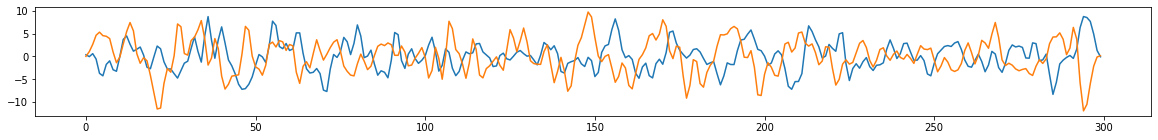

In [44]:
templates = np.copy(model.estimators_[0].templates_)
plt.figure(figsize=(20,2))
plt.plot(templates[28,14])
# plt.plot(templates[29,14])
plt.plot(templates[30,14])
# plt.plot(templates[31,14])

In [229]:
templates = np.copy(model.estimators_[0].templates_)
n_comp = model.estimators_[0].n_components
Us = model.estimators_[0].Us_
for i_template, template in enumerate(templates):
    # templates[i_template] = Us[i_template,:,:n_comp].T@template
    templates[i_template] = np.reshape((Us[i_template,:,:n_comp].T@template),-1)

In [231]:
templates.shape

(32, 19, 300)

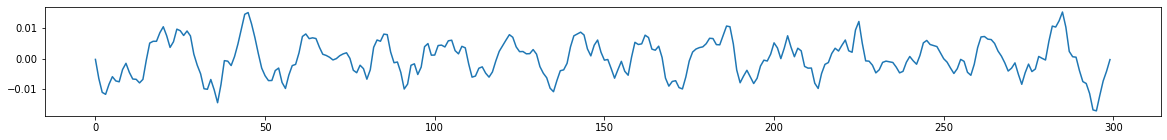

In [235]:
plt.figure(figsize=(20,2))
plt.plot(templates[28,0])
# plt.plot(templates[29,14])
# plt.plot(templates[30,0])
# plt.plot(templates[31,14])

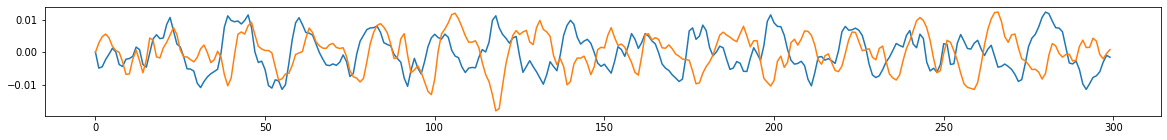

In [48]:
plt.figure(figsize=(20,2))
# plt.plot(templates[28,13])
plt.plot(templates[29,13])
# plt.plot(templates[30,13])
plt.plot(templates[31,13])

In [335]:
templates = np.copy(model.estimators_[0].templates_)
U = np.copy(model.estimators_[0].Us_)[:, :, :model.n_components]
U = np.concatenate(U, axis=-1)
new_templates=np.zeros((templates.shape[0],templates.shape[0]*templates.shape[2]))
for i_template, template in enumerate(templates):
    new_templates[i_template] = np.reshape((U.T@template),(-1))
templates = np.copy(new_templates)
templates.shape

(32, 1440)

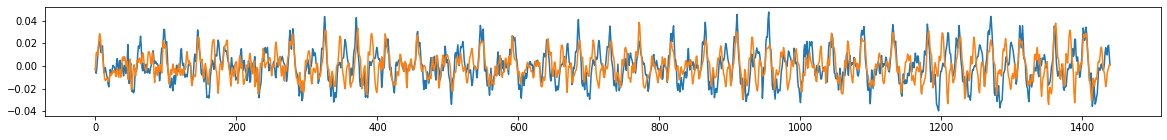

In [343]:
plt.figure(figsize=(20,2))
t_length=int(templates.shape[1]/templates.shape[0])
# # plt.plot(templates[28,:300])
# for i in [1,2,3,4,6,7,11,19,21,22,23,24,25,26,27,28,29,30]:
#     # if i == 0:
#     #     continue
#     plt.plot(templates[28,i*t_length:(i+1)*t_length])
plt.plot(templates[28])
# plt.plot(templates[25])
plt.plot(templates[30])

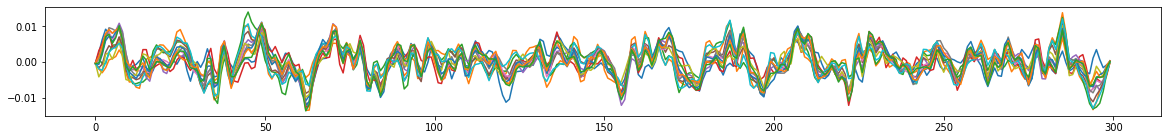

In [297]:
plt.figure(figsize=(20,2))
# plt.plot(templates[28,:300])
for i in [0,5,8,9,10,12,13,14,15,16,17,18,20]:
    # if i == 0:
    #     continue
    plt.plot(templates[28,i*300:(i+1)*300])

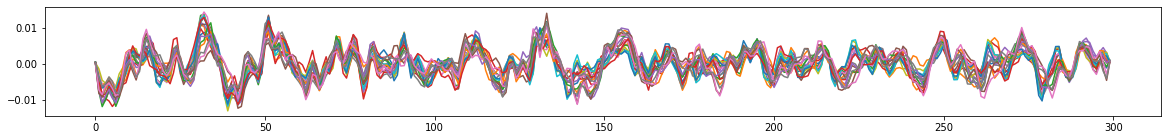

In [302]:
plt.figure(figsize=(20,2))
# plt.plot(templates[28,:300])
for i in [1,2,3,4,6,7,11,19,21,22,23,24,25,26,27,28,29,30]:
    # if i == 0:
    #     continue
    plt.plot(templates[31,i*300:(i+1)*300])

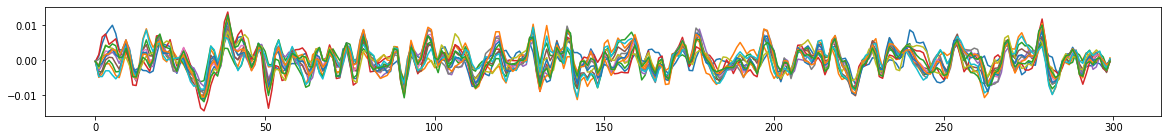

In [303]:
plt.figure(figsize=(20,2))
# plt.plot(templates[28,:300])
for i in [0,5,8,9,10,12,13,14,15,16,17,18,20]:
    # if i == 0:
    #     continue
    plt.plot(templates[31,i*300:(i+1)*300])

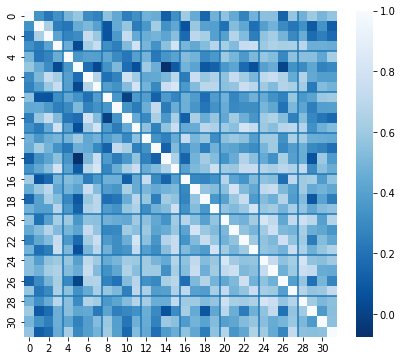

In [345]:
n_classes = 32
class_num = 28
t_length=int(templates.shape[1]/templates.shape[0])
corrs = np.zeros((n_classes,n_classes))
for i in range(n_classes):
    for j in range(n_classes):
        a1 = templates[i]
        a2 = templates[j]
        corrs[i,j] = pearsonr(a1,a2)[0]
plt.figure(figsize=(7, 6))
ax = sns.heatmap(corrs,cmap='Blues_r')
ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())

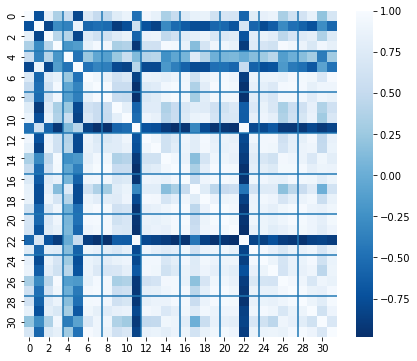

In [344]:
n_classes = 32
class_num = 28
t_length=int(templates.shape[1]/templates.shape[0])
corrs = np.zeros((n_classes,n_classes))
for i in range(n_classes):
    for j in range(n_classes):
        a1 = templates[class_num,i*t_length:(i+1)*t_length]
        a2 = templates[class_num,j*t_length:(j+1)*t_length]
        corrs[i,j] = pearsonr(a1,a2)[0]
plt.figure(figsize=(7, 6))
ax = sns.heatmap(corrs,cmap='Blues_r')
ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())

333.4238281451512


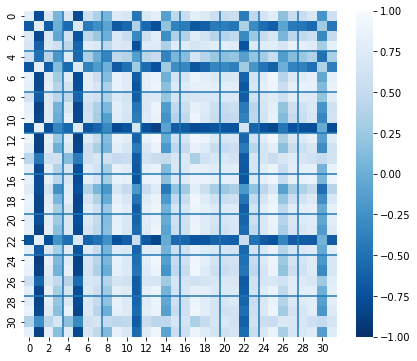

In [346]:
n_classes = 32
class_num1 = 29
class_num2 = 25
t_length=int(templates.shape[1]/templates.shape[0])
corrs = np.zeros((n_classes,n_classes))
for i in range(n_classes):
    for j in range(n_classes):
        a1 = templates[class_num1,i*t_length:(i+1)*t_length]
        a2 = templates[class_num2,j*t_length:(j+1)*t_length]
        corrs[i,j] = pearsonr(a1,a2)[0]
print(corrs.sum())
plt.figure(figsize=(7, 6))
ax = sns.heatmap(corrs,cmap='Blues_r',vmin=-1,vmax=1)
ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())

337.682375692743


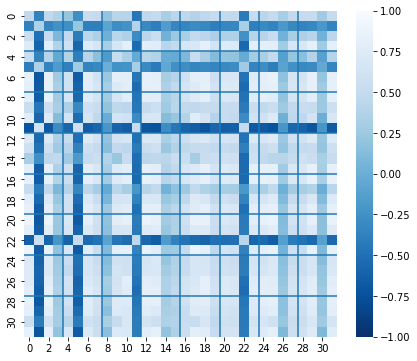

In [347]:
n_classes = 32
class_num1 = 29
class_num2 = 24
t_length=int(templates.shape[1]/templates.shape[0])
corrs = np.zeros((n_classes,n_classes))
for i in range(n_classes):
    for j in range(n_classes):
        a1 = templates[class_num1,i*t_length:(i+1)*t_length]
        a2 = templates[class_num2,j*t_length:(j+1)*t_length]
        corrs[i,j] = pearsonr(a1,a2)[0]
print(corrs.sum())
plt.figure(figsize=(7, 6))
ax = sns.heatmap(corrs,cmap='Blues_r',vmin=-1,vmax=1)
ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())

36.86300458898549


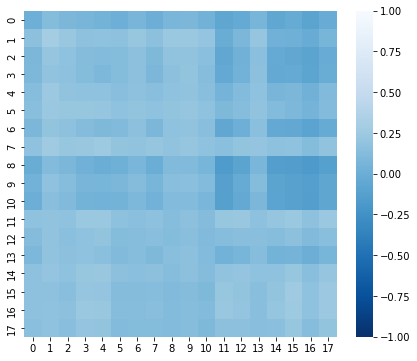

In [326]:
selected_classes = [1,2,3,4,6,7,11,19,21,22,23,24,25,26,27,28,29,30]
n_classes = len(selected_classes)
class_num1 = 29
class_num2 = 25
corrs = np.zeros((n_classes,n_classes))
for ii,i in enumerate(selected_classes):
    for jj,j in enumerate(selected_classes):
        a1 = templates[class_num1,i*300:(i+1)*300]
        a2 = templates[class_num2,j*300:(j+1)*300]
        corrs[ii,jj] = pearsonr(a1,a2)[0]
print(corrs.sum())
plt.figure(figsize=(7, 6))
ax = sns.heatmap(corrs,cmap='Blues_r',vmin=-1,vmax=1)
# ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
# ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())

24.40263422508854


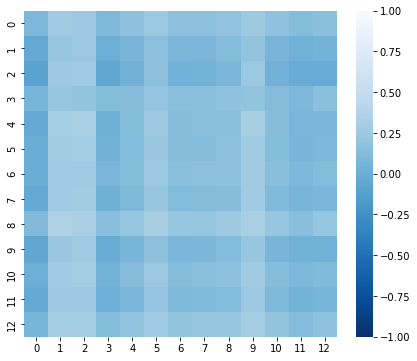

In [327]:
selected_classes = [0,5,8,9,10,12,13,14,15,16,17,18,20]
n_classes = len(selected_classes)
class_num1 = 29
class_num2 = 25
corrs = np.zeros((n_classes,n_classes))
for ii,i in enumerate(selected_classes):
    for jj,j in enumerate(selected_classes):
        a1 = templates[class_num1,i*300:(i+1)*300]
        a2 = templates[class_num2,j*300:(j+1)*300]
        corrs[ii,jj] = pearsonr(a1,a2)[0]
print(corrs.sum())
plt.figure(figsize=(7, 6))
ax = sns.heatmap(corrs,cmap='Blues_r',vmin=-1,vmax=1)

In [315]:
a1 = templates[29]
a2 = templates[25]
pearsonr(a1,a2)[0]

0.162947379733056

In [319]:
a1 = templates[29]
a2 = templates[24]
pearsonr(a1,a2)[0]

0.013778695600910197

In [313]:
templates.shape

(32, 9600)

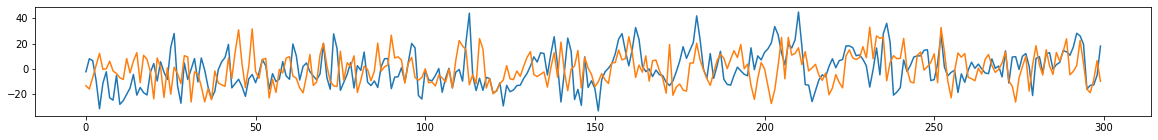

In [79]:
eegX = np.copy(testX)
plt.figure(figsize=(20,2))
plt.plot(eegX[28,14])
# plt.plot(templates[29,14])
plt.plot(eegX[30,14])
# plt.plot(templates[31,14])

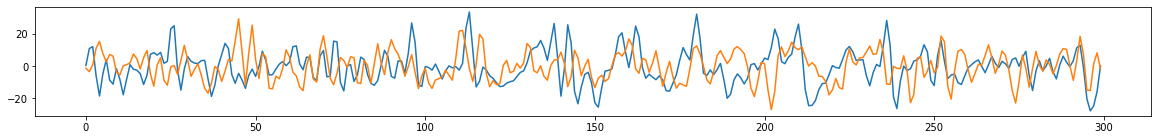

In [80]:
eegX = np.copy(testX)
eegX_fb = model.transform_filterbank(eegX)
plt.figure(figsize=(20,2))
plt.plot(eegX_fb[0,28,14])
# plt.plot(templates[29,14])
plt.plot(eegX_fb[0,30,14])
# plt.plot(templates[31,14])

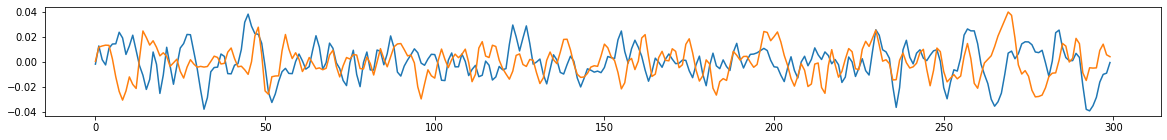

In [81]:
eegX = np.copy(testX)
eegX_fb = model.transform_filterbank(eegX)
n_comp = model.estimators_[0].n_components
Us = model.estimators_[0].Us_
for i_x, x in enumerate(eegX_fb[0]):
    # templates[i_template] = Us[i_template,:,:n_comp].T@template
    # templates[i_template] = np.reshape((Us[i_template,:,:n_comp].T@template),-1)
    eegX_fb[0,i_x] = np.reshape((Us[i_x,:,:n_comp].T@x),-1)
plt.figure(figsize=(20,2))
plt.plot(eegX_fb[0,28,14])
# plt.plot(templates[29,14])
plt.plot(eegX_fb[0,30,14])
# plt.plot(templates[31,14])

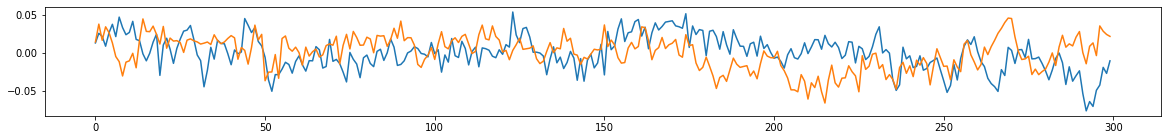

In [65]:
eegX = np.copy(testX)
n_comp = model.estimators_[0].n_components
Us = model.estimators_[0].Us_
for i_x, x in enumerate(eegX):
    # templates[i_template] = Us[i_template,:,:n_comp].T@template
    # templates[i_template] = np.reshape((Us[i_template,:,:n_comp].T@template),-1)
    eegX[i_x] = np.reshape((Us[i_x,:,:n_comp].T@x),-1)
plt.figure(figsize=(20,2))
plt.plot(eegX[28,14])
# plt.plot(templates[29,14])
plt.plot(eegX[30,14])
# plt.plot(templates[31,14])

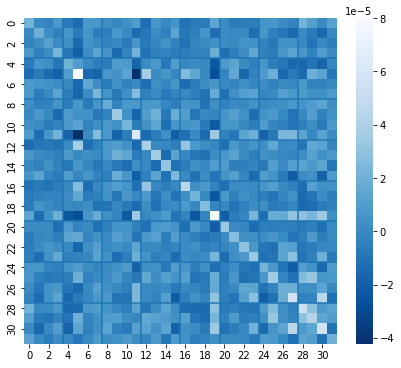

In [63]:
templates = np.copy(model.estimators_[0].templates_[:,:,:60])
# templates = np.copy(model.estimators_[0].templates_[:,:,30:])
n_comp = model.estimators_[0].n_components
Us = model.estimators_[0].Us_
for i_template, template in enumerate(templates):
    # templates[i_template] = Us[i_template,:,:n_comp].T@template
    templates[i_template] = np.reshape((Us[i_template,:,:n_comp].T@template),-1)
chan_n = 13
seq_len = templates.shape[2]
corrs = np.zeros((n_classes,n_classes))
for i in range(n_classes):
    for j in range(n_classes):
        a1 = templates[i,chan_n]
        a2 = templates[j,chan_n]
        corrs[i,j] = (a1 * a2).sum()/seq_len
        # corrs[i,j] = pearsonr(a1,a2)[0]
plt.figure(figsize=(7, 6))
ax = sns.heatmap(corrs,cmap='Blues_r')
ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())

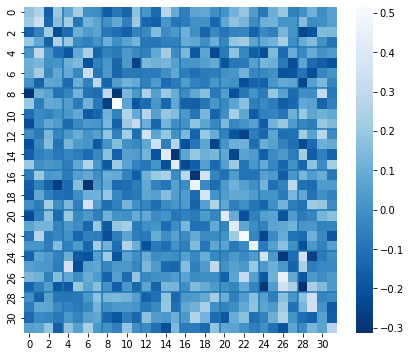

In [83]:
templates = np.copy(model.estimators_[0].templates_[:,:,:])
eegX = model.transform_filterbank(np.copy(testX))[0,:,:,:]
# templates = np.copy(model.estimators_[0].templates_[:,:,30:])
n_comp = model.estimators_[0].n_components
Us = model.estimators_[0].Us_
for i_template, template in enumerate(templates):
    # templates[i_template] = Us[i_template,:,:n_comp].T@template
    templates[i_template] = np.reshape((Us[i_template,:,:n_comp].T@template),-1)
for i_x, x in enumerate(eegX):
    eegX[i_x] = np.reshape((Us[i_x,:,:n_comp].T@x),-1)
chan_n = 13
seq_len = templates.shape[2]
corrs = np.zeros((n_classes,n_classes))
for i in range(n_classes):
    for j in range(n_classes):
        a1 = templates[i,chan_n]
        # a2 = templates[j,chan_n]
        a2 = eegX[j,chan_n]
        # corrs[i,j] = (a1 * a2).sum()/seq_len
        corrs[i,j] = pearsonr(a1,a2)[0]
plt.figure(figsize=(7, 6))
ax = sns.heatmap(corrs,cmap='Blues_r')
ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())

(32, 3, 32)


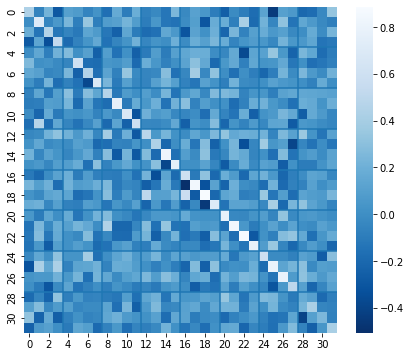

In [73]:
probs = model.transform(testX)
plt.figure(figsize=(7, 6))
ax = sns.heatmap(probs,cmap='Blues_r')
ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())

In [331]:
# eeg, target_by_trial, target_tab = load_dataset()
trial_duration = 0.15
onset_delay = 30
pms, acc, model = run_fbtrca(eeg, target_by_trial, target_tab, duration=trial_duration, onset_delay=onset_delay,return_prob=True, ensamble=False)

Model:fbtrca LOO Acc:0.12


In [334]:
# eeg, target_by_trial, target_tab = load_dataset()
trial_duration = 0.15
onset_delay = 30
txms, acc, model = run_fbtrca(eeg, target_by_trial, target_tab, duration=trial_duration, onset_delay=onset_delay,return_template_xcorr=True)

Model:fbtrca LOO Acc:0.21


In [201]:
# eeg, target_by_trial, target_tab = load_dataset()
trial_duration = 0.15
onset_delay = 30
mxms, acc, model = run_fbtrca(eeg, target_by_trial, target_tab, duration=trial_duration, onset_delay=onset_delay,return_matching_xcorr=True)

In [157]:
templates.shape,template.shape

((32, 19, 300), (19, 300))

In [165]:
(U.T@template).shape

(32, 300)

In [172]:
U.shape

(19, 32)

In [ ]:
pms_sum = []
for i in range(20):
    pms_sum.append(pms[i])
    pms_sum_np = np.array(pms_sum).sum(axis=0)
    plt.figure(figsize=(7, 6))
    ax = sns.heatmap(pms_sum_np,cmap='Blues_r')
    ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
    ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())

In [ ]:
txms_sum = []
for i in range(20):
    txms_sum.append(txms[i])
    txms_sum_np = np.array(txms_sum).sum(axis=0)
    plt.figure(figsize=(7, 6))
    ax = sns.heatmap(txms_sum_np,cmap='Blues_r')
    # ax = sns.heatmap(txms[i],cmap='Blues_r')
    ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
    ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())

In [ ]:
mxms_sum = []
for i in range(20):
    mxms_sum.append(mxms[i])
    mxms_sum_np = np.array(mxms_sum).sum(axis=0)
    plt.figure(figsize=(7, 6))
    ax = sns.heatmap(mxms_sum_np,cmap='Blues_r')
    # ax = sns.heatmap(txms[i],cmap='Blues_r')
    ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
    ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())

In [171]:
n_components = model.n_components
print(model.estimators_[0].Us_[:, :, :n_components].shape)
print(model.ensemble)
U = model.estimators_[0].Us_[:, :, :n_components]
U = np.concatenate(U, axis=-1)

(32, 19, 1)
True


In [117]:
model.predict(eeg[:,0,:,42:347])

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 22,  0,  0,  0,  0,
        0, 15,  0])

<BarContainer object of 32 artists>

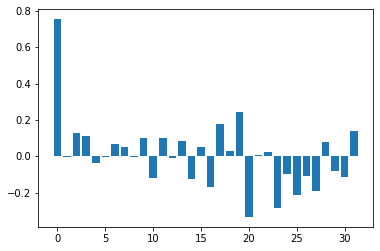

In [20]:
plt.bar(x=range(32),height=model.transform(eeg[0,0,:,42:])[0])

<BarContainer object of 32 artists>

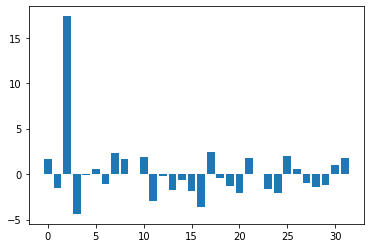

In [28]:
plt.bar(x=range(32),height=model.transform(eeg[:,2,:,42:]).sum(axis=0))

In [29]:
prob_matrix = np.zeros((32,32))
for i in range(32):
    prob_matrix[i]=model.transform(eeg[:,i,:,42:]).sum(axis=0)

In [93]:
n_bands = 3
freq_targets = np.array(target_by_trial)[0,:,0]
phase_targets = np.array(target_by_trial)[0,:,1]
n_harmonics = 5
Yf = generate_cca_references(
    freq_targets, srate, duration, 
    phases=phase_targets, 
    n_harmonics=n_harmonics)
wp = [[8*i, 90] for i in range(1, n_bands+1)]
ws = [[8*i-2, 95] for i in range(1, n_bands+1)]
filterbank = generate_filterbank(
    wp, ws, srate, order=4, rp=1)
filterweights = np.arange(1, len(filterbank)+1)**(-1.25) + 0.25
set_random_seeds(64)
# model = FBTDCA(
#             filterbank, l, n_components=8, 
#             filterweights=filterweights).fit(
#                 trainX, trainY,
#                 Yf=Yf
#             )
model = FBTRCA(
            filterbank, 
            filterweights=filterweights).fit(
                trainX, trainY
            )

In [119]:
model.base_estimator.templates_.shape, model.base_estimator.Us_.shape

((32, 19, 300), (32, 19, 19))

In [169]:
templates = np.copy(model.base_estimator.templates_)
n_comp = model.base_estimator.n_components
Us = model.base_estimator.Us_
for i_template, template in enumerate(templates):
    # templates[i_template] = Us[i_template,:,:n_comp].T@template
    templates[i_template] = np.reshape((Us[i_template,:,:n_comp].T@template),-1)

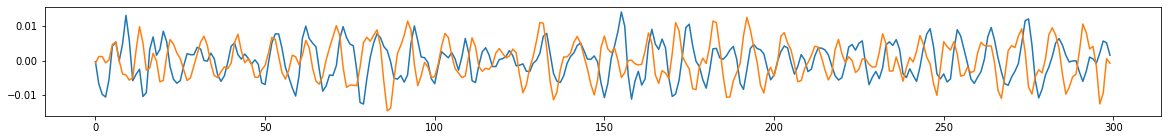

In [171]:
plt.figure(figsize=(20,2))
plt.plot(templates[28,14])
# plt.plot(templates[29,14])
plt.plot(templates[30,14])
# plt.plot(templates[31,14])

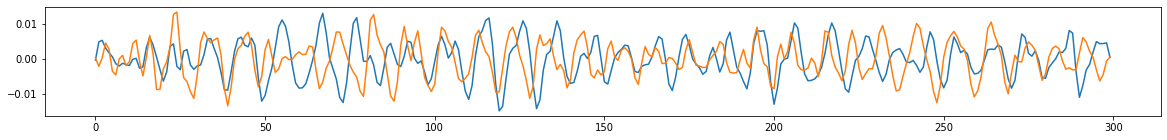

In [173]:
plt.figure(figsize=(20,2))
# plt.plot(templates[28,13])
plt.plot(templates[29,13])
# plt.plot(templates[30,13])
plt.plot(templates[31,13])

In [130]:
(model.base_estimator.templates_[26,13] * model.base_estimator.templates_[30,13]).sum()

-140.77581638736345

In [142]:
model.base_estimator.n_components

1

In [187]:
testY, testX.shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 (32, 19, 300))

In [5]:
model.predict(testX)

array([ 0,  1,  2,  3,  4,  5, 22, 25,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 27, 30, 31])

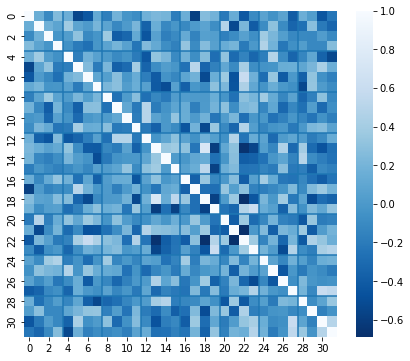

In [184]:
templates = np.copy(model.base_estimator.templates_[:,:,30:30+75])
# templates = np.copy(model.base_estimator.templates_[:,:,30:])
n_comp = model.base_estimator.n_components
Us = model.base_estimator.Us_
for i_template, template in enumerate(templates):
    # templates[i_template] = Us[i_template,:,:n_comp].T@template
    templates[i_template] = np.reshape((Us[i_template,:,:n_comp].T@template),-1)
chan_n = 13
seq_len = templates.shape[2]
corrs = np.zeros((n_classes,n_classes))
for i in range(n_classes):
    for j in range(n_classes):
        a1 = templates[i,chan_n]
        a2 = templates[j,chan_n]
        # corrs[i,j] = (a1 * a2).sum()/seq_len
        corrs[i,j] = pearsonr(a1,a2)[0]
plt.figure(figsize=(7, 6))
ax = sns.heatmap(corrs,cmap='Blues_r')
ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())

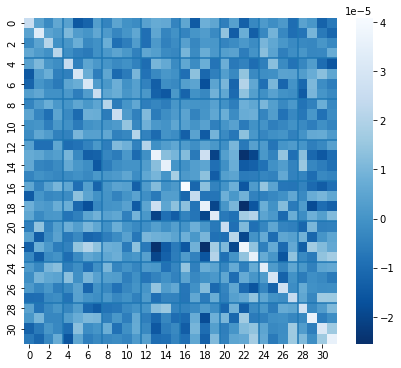

In [185]:
templates = np.copy(model.base_estimator.templates_[:,:,30:30+75])
# templates = np.copy(model.base_estimator.templates_[:,:,30:])
n_comp = model.base_estimator.n_components
Us = model.base_estimator.Us_
for i_template, template in enumerate(templates):
    # templates[i_template] = Us[i_template,:,:n_comp].T@template
    templates[i_template] = np.reshape((Us[i_template,:,:n_comp].T@template),-1)
chan_n = 13
seq_len = templates.shape[2]
corrs = np.zeros((n_classes,n_classes))
for i in range(n_classes):
    for j in range(n_classes):
        a1 = templates[i,chan_n]
        a2 = templates[j,chan_n]
        corrs[i,j] = (a1 * a2).sum()/seq_len
        # corrs[i,j] = pearsonr(a1,a2)[0]
plt.figure(figsize=(7, 6))
ax = sns.heatmap(corrs,cmap='Blues_r')
ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())

In [152]:
np.reshape((Us[i_template,:,:n_comp].T@template),-1).shape

(45,)

In [151]:
templates.shape

(32, 19, 45)

In [176]:
pearsonr(a1,a2)[0]

0.9999999999999998

<AxesSubplot:>

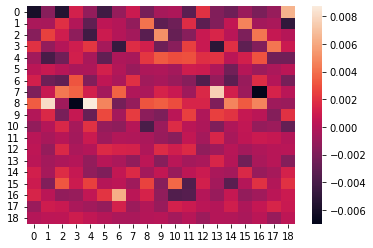

In [116]:
sns.heatmap(model.base_estimator.Us_[10])

In [96]:
# model.base_estimator.templates_.shape, model.base_estimator.M_.shape, model.base_estimator.W_.shape, len(model.base_estimator.Ps_)

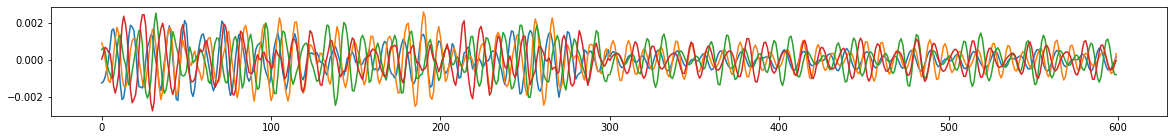

In [68]:
plt.figure(figsize=(20,2))
plt.plot(model.base_estimator.templates_[0,0])
plt.plot(model.base_estimator.templates_[1,0])
plt.plot(model.base_estimator.templates_[3,0])
plt.plot(model.base_estimator.templates_[4,0])

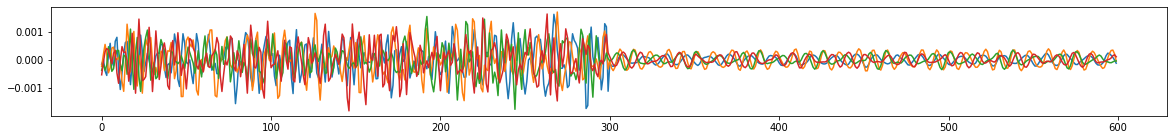

In [73]:
plt.figure(figsize=(20,2))
plt.plot(model.base_estimator.templates_[0,31])
plt.plot(model.base_estimator.templates_[1,31])
plt.plot(model.base_estimator.templates_[3,31])
plt.plot(model.base_estimator.templates_[4,31])

In [85]:
trainX.shape

(608, 19, 305)

In [82]:
model.transform(testX[:3]).shape

(3, 32)

In [116]:
model.base_estimator.templates

AttributeError: 'TDCA' object has no attribute 'templates'

In [79]:
testX.shape

(32, 19, 305)

<AxesSubplot:>

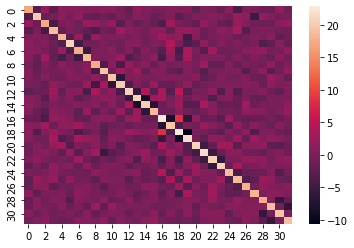

In [34]:
sns.heatmap(prob_matrix)

<AxesSubplot:>

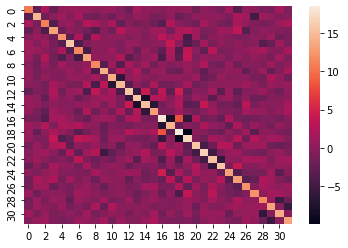

In [38]:
prob_matrix = np.zeros((32,32))

onset_delay = 42
srate = 300
duration = 1
eeg = np.copy(eeg)
np.random.seed(64)
np.random.shuffle(eeg)
n_trials = eeg.shape[0]
classes = range(32)
n_classes = len(classes)
y = np.array([list(target_tab.values())] * n_trials).T.reshape(-1)
eeg_temp = eeg[:n_trials,classes,:,onset_delay:]
X = eeg_temp.swapaxes(0,1).reshape(-1,*eeg_temp.shape[2:])


freq_targets = np.array(target_by_trial)[0,:,0]
phase_targets = np.array(target_by_trial)[0,:,1]
n_harmonics = 5
n_bands = 3
Yf = generate_cca_references(
    freq_targets, srate, duration, 
    phases=phase_targets, 
    n_harmonics=n_harmonics)
wp = [[8*i, 90] for i in range(1, n_bands+1)]
ws = [[8*i-2, 95] for i in range(1, n_bands+1)]
filterbank = generate_filterbank(
    wp, ws, srate, order=4, rp=1)
filterweights = np.arange(1, len(filterbank)+1)**(-1.25) + 0.25
set_random_seeds(64)
l = 5

# models = OrderedDict([
#     ('fbtdca', FBTDCA(
#             filterbank, l, n_components=8, 
#             filterweights=filterweights)),
# ])

events = []
for j_class in classes:
    events.extend([str(target_by_trial[i_trial][j_class]) for i_trial in range(n_trials)])
events = np.array(events)
subjects = ['1'] * (n_classes*n_trials)
meta = pd.DataFrame(data=np.array([subjects,events]).T, columns=["subject", "event"])
set_random_seeds(42)
loo_indices = generate_loo_indices(meta)

filterX, filterY = np.copy(X[..., :int(srate*duration)+l]), np.copy(y)
filterX = filterX - np.mean(filterX, axis=-1, keepdims=True)

n_loo = len(loo_indices['1'][events[0]])
loo_accs = []
testYs = []
pred_labelss = []
for k in range(n_loo):
    train_ind, validate_ind, test_ind = match_loo_indices(
        k, meta, loo_indices)
    train_ind = np.concatenate([train_ind, validate_ind])
    trainX, trainY = filterX[train_ind], filterY[train_ind]
    testX, testY = filterX[test_ind], filterY[test_ind]
    model = FBTDCA(
            filterbank, l, n_components=8, 
            filterweights=filterweights).fit(
                trainX, trainY,
                Yf=Yf
            )
    pred_labels = model.predict(testX)
    prob_matrix+=model.transform(testX)
    loo_accs.append(
        balanced_accuracy_score(testY, pred_labels))
    pred_labelss.extend(pred_labels)
    testYs.extend(testY)
sns.heatmap(prob_matrix)

<AxesSubplot:>

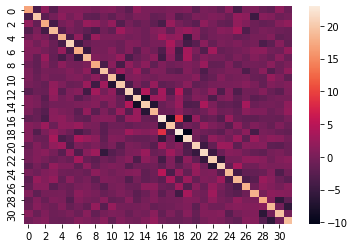

In [36]:
prob_matrix = np.zeros((32,32))
for i in range(32):
    prob_matrix[i]=model.transform(eeg[:,i,:,42:]).sum(axis=0)
sns.heatmap(prob_matrix)

In [37]:
model.transform(testX).shape

(32, 32)

In [49]:
active_info([1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0], k=4)

1.0

In [50]:
active_info([1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0], k=4)

0.5149798205164813

In [54]:
active_info([1,0,1,0,1,1,0,0,0,0,1,0,1,1,0,1,1,1,0,1,0,1,0,0], k=4, local=True)

array([[ 0.4150375,  0.4150375,  0.4150375,  0.       ,  1.       ,
         1.       ,  1.       ,  1.       ,  1.       ,  0.4150375,
         0.4150375,  0.       ,  0.       , -0.5849625,  1.       ,
         1.       ,  0.       ,  0.4150375, -0.5849625, -0.5849625]])

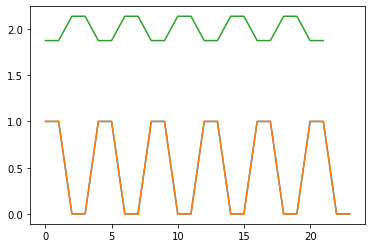

In [77]:
# flashes=[1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0]
# flashes=[1,0,1,0,1,1,0,0,0,0,1,0,1,1,0,1,1,1,0,1,0,1,0,0]
flashes1=[1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0]
# flashes2=[1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1]
# flashes2=[0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1]
flashes2=[1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0]
# flashes2=[1,1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0]

# active_info([[0,0,1,1,1,1,0,0,0], [1,0,0,1,0,0,1,0,0]], k=2, local=True)
plt.plot(flashes1)
plt.plot(flashes2)
plt.plot(block_entropy([flashes1,flashes2], k=3, local=True)[0])

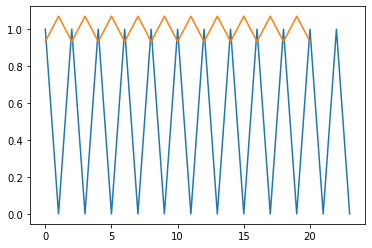

In [68]:
flashes=[1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
plt.plot(flashes)
plt.plot(active_info(flashes, k=3, local=True)[0])